In [ ]:
# Seasonal Autoregressive Integrated Moving Average (SARIMAX) captures historical values, shock events and seasonality
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
# https://builtin.com/data-science/time-series-forecasting-python

from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas import read_csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# one-step sarima forecast
def sarima_forecast(history, config):
 order, sorder, trend = config
 # define model
 model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
 # fit model
 model_fit = model.fit(disp=False)
 # make one step forecast
 yhat = model_fit.predict(len(history), len(history))
 return yhat[0]

In [ ]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
 return sqrt(mean_squared_error(actual, predicted))

In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
 return data[:-n_test], data[-n_test:]

In [ ]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

In [ ]:
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

In [ ]:
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

In [ ]:
# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

In [109]:
# using yahoo data with Bitcoin cost averaged by month to test a model
import yfinance as yf
import datetime
btc = yf.download('BTC-USD', start=datetime.datetime(2018, 1, 1), end=datetime.datetime(2023, 12, 31))
print(btc.head())

[*********************100%%**********************]  1 of 1 completed

                    Open          High           Low         Close  \
Date                                                                 
2018-01-01  14112.200195  14112.200195  13154.700195  13657.200195   
2018-01-02  13625.000000  15444.599609  13163.599609  14982.099609   
2018-01-03  14978.200195  15572.799805  14844.500000  15201.000000   
2018-01-04  15270.700195  15739.700195  14522.200195  15599.200195   
2018-01-05  15477.200195  17705.199219  15202.799805  17429.500000   

               Adj Close       Volume  
Date                                   
2018-01-01  13657.200195  10291200000  
2018-01-02  14982.099609  16846600192  
2018-01-03  15201.000000  16871900160  
2018-01-04  15599.200195  21783199744  
2018-01-05  17429.500000  23840899072  


In [ ]:
# choosing the best model
if __name__ == '__main__':
	# load dataset
	series=btc.groupby(pd.PeriodIndex(btc.index, freq="M"))['Close'].mean()
	data = series.values
	print(data.shape)
	# data split
	n_test = 12
	# model configs
	cfg_list = sarima_configs(seasonal=[0,6,12])
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

(72,)
 > Model[[(0, 0, 0), (0, 0, 0, 0), 'n']] 29369.472
 > Model[[(0, 0, 0), (0, 0, 0, 6), 'n']] 29369.472
 > Model[[(0, 0, 0), (0, 0, 0, 12), 'n']] 29369.472
 > Model[[(0, 0, 0), (0, 0, 1, 6), 'n']] 21589.425
 > Model[[(0, 0, 0), (0, 0, 1, 12), 'n']] 45237.648
 > Model[[(0, 0, 0), (0, 0, 2, 6), 'n']] 14872.043
 > Model[[(0, 0, 0), (0, 1, 0, 6), 'n']] 7911.550
 > Model[[(0, 0, 0), (0, 1, 0, 12), 'n']] 14361.116
 > Model[[(0, 0, 0), (0, 1, 1, 6), 'n']] 8412.876 > Model[[(0, 0, 0), (0, 0, 2, 12), 'n']] 22502.750

 > Model[[(0, 0, 0), (0, 1, 2, 6), 'n']] 6321.440
 > Model[[(0, 0, 0), (0, 1, 1, 12), 'n']] 11067.394
 > Model[[(0, 0, 0), (1, 0, 0, 6), 'n']] 9780.047
 > Model[[(0, 0, 0), (1, 0, 0, 12), 'n']] 14068.757
 > Model[[(0, 0, 0), (1, 0, 1, 6), 'n']] 10963.967
 > Model[[(0, 0, 0), (1, 0, 1, 12), 'n']] 19157.858
 > Model[[(0, 0, 0), (0, 1, 2, 12), 'n']] 18028.785
 > Model[[(0, 0, 0), (1, 0, 2, 6), 'n']] 10242.660
 > Model[[(0, 0, 0), (1, 1, 0, 6), 'n']] 8405.164
 > Model[[(0, 0, 0), (

In [112]:
# best model parameters
eval(scores[0][0])

[(1, 0, 1), (0, 0, 1, 12), 't']

In [113]:
# training final model with the best parameters
predictions = list()
# split dataset
train, test = train_test_split(data, n_test)
# seed history with training dataset
history = [x for x in train]
# step over each time-step in the test set
for i in range(len(test)):
	# fit the best model and make forecast for history
	yhat = sarima_forecast(history,eval(scores[0][0]))
	# store forecast in list of predictions
	predictions.append(yhat)
	# # add actual observation to history for the next loop
	history.append(test[i])

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

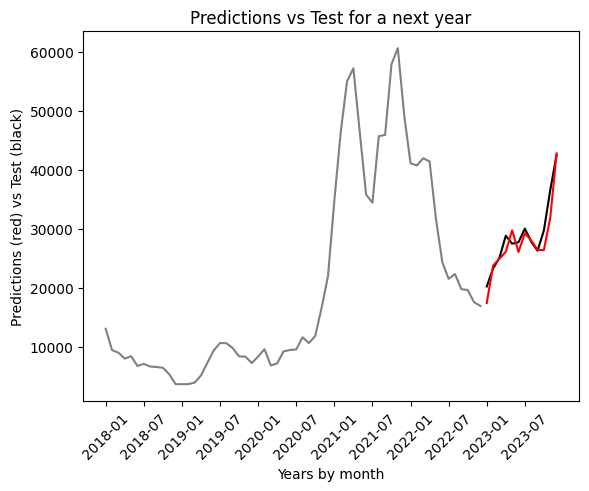

In [114]:
# plots
plt.plot(series.index[:-n_test].astype(str), train, color = "grey")
plt.plot(series.index[-n_test:].astype(str), test, color = "black")
plt.plot(series.index[-n_test:].astype(str), predictions, color = "red")
plt.ylabel('Predictions (red) vs Test (black)')
plt.xlabel('Years by month')
plt.xticks(np.arange(0, len(series.index), step=6), rotation=45)
plt.title("Predictions vs Test for a next year")
plt.show()